In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [2]:
sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')


In [3]:
from modules.data_handling import load_and_normalize_data, split_dataset, create_validation_set
from modules.prediction_storage import store_predictions
from modules.fusion_methods import compute_neg_log_like, product_fusion, train_and_predict_fusion_method
from modules.model_training import train_and_predict_single_gp, train_expert, store_predictions_for_experts
from modules.phs import phs
from modules.bhs import bhs
from modules.model_training import train_joint_experts_shared_kernel


In [4]:
# ------------ Load and normalize data --------- #
dataset_name = "concrete"
split=0
X_train, y_train, X_test, y_test = load_and_normalize_data(dataset_name, 
                                                           split,
                                                           normalize_x_method="max-min",
                                                           normalize_y=True)

print("training size: ", len(y_train))
print("test size: ", len(y_test))

training size:  927
test size:  103


In [5]:
n_experts = 3
n_points_per_split = 5
splits = split_dataset(X_train, y_train, n_splits=n_experts, with_replacement=False)
X_val, y_val = create_validation_set(splits, n_points_per_split)

In [6]:
for split in splits:
    print(split[0].shape[0])

309
309
309


In [7]:
kappa = 2
lambdaa = 2
training_iter = 100
lr = 0.1

joint_training = False

if joint_training:
    print("Experts are trained jointly")
    # ====== for joint training ========== #
    models, likelihood = train_joint_experts_shared_kernel(splits, kappa, lambdaa,
                                                           lr=lr,
                                                           training_iter=training_iter)
    experts = [(model,likelihood) for model in models]
    # ====== for independent training ==== #
else:
    print("Experts are trained independently")
    experts = []
    for X_split, y_split in splits:
        model, likelihood = train_expert(X_split, y_split, kappa, lambdaa,
                                         lr=lr,
                                         training_iter=training_iter)
        experts.append((model, likelihood))


# Store predictions for experts on the test set
mu_preds_test, std_preds_test, std_preds_prior_test = store_predictions_for_experts(experts, X_test)

# Compute negative log likelihood for experts
nlpd_experts = compute_neg_log_like(mu_preds_test, std_preds_test, y_test)
print(nlpd_experts, nlpd_experts.mean())

# Store predictions for experts on the validation set
mu_preds_val, std_preds_val, _ = store_predictions_for_experts(experts, X_val) # we don't need the prior predictive variances here...


Experts are trained independently
[0.26150755 0.39444994 0.33829173] 0.33141640952621004


In [8]:
# ---------  Single GP using all training data ----- #
test_preds, _ = train_and_predict_single_gp(X_train, y_train, X_test, X_val, kappa, lambdaa,
                                            lr=lr,
                                            training_iter=training_iter)
nlpd_single_gp = compute_neg_log_like(test_preds.mean.numpy().reshape(-1, 1), 
                                      np.sqrt(test_preds.variance.numpy().reshape(-1, 1)), y_test)
print(nlpd_single_gp.squeeze())

0.46498216326339104


# Testing tne different stacking algorithms:
PHS with MCMC or VI (AutoDelta or AutoNormal)

BHS with MCMC or VI (AutoDelta or AutoNormal)

RFF-based PHS with MCMC or VI (coming soon...)

RFF-based BHS with MCMC or VI (coming soon...)

## PHS

In [9]:
preds, lpd = train_and_predict_fusion_method(
                                phs,
                                X_val,
                                mu_preds_val,
                                std_preds_val,
                                y_val,
                                X_test,
                                mu_preds_test,
                                std_preds_test,
                                y_test,
                                method="mcmc",
                                )

In [10]:
preds["w"].shape

(400, 3, 103)

0.17879987


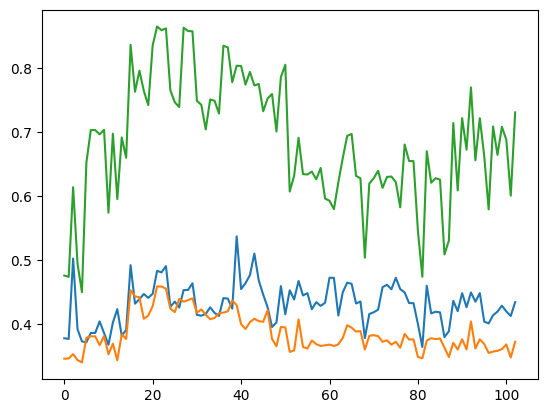

In [11]:
nlpd_phs_mcmc = -lpd.mean()
for i in range(n_experts):
    plt.plot(preds["w"].mean(0)[i,:])
print(nlpd_phs_mcmc)    

In [12]:
preds, lpd = train_and_predict_fusion_method(
                                phs,
                                X_val,
                                mu_preds_val,
                                std_preds_val,
                                y_val,
                                X_test,
                                mu_preds_test,
                                std_preds_test,
                                y_test,
                                method="svi",
                                guide_svi="map",
                                )

ValueError: Optimizer should be an instance of pyro.optim.PyroOptim class.